In [215]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from kneed import KneeLocator

from scipy.cluster import hierarchy

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Clustering algorithm

In [178]:
df_norm = pd.read_csv('df/6_clear_normalised.csv')

In [233]:
# divide the data
X_norm = df_norm.drop(columns=['raw_value'], axis = 1)
Y = df_norm['raw_value']

In [180]:
# perform t-SNE
tsne = TSNE(n_components = 2, perplexity = 25, random_state=0)
X_tsne = tsne.fit_transform(X_norm)

What we know about our data is this:
* Have a high dimensionality
* Have outliers and noise
* Have overlapping clusters
* The data are presented in a numerical format

The most frequent and "classic" clustering method is considered k-means, which refers to **Centroid-based clustering**. However, it interacts poorly with outliers, but it does not require computational costs and is designed for numerical data. At least with its help we will be able to determine the approximate number of clusters.

**K-Means clustering**

Determine the number of clusters for the k-means method by calculating the sums of squared errors

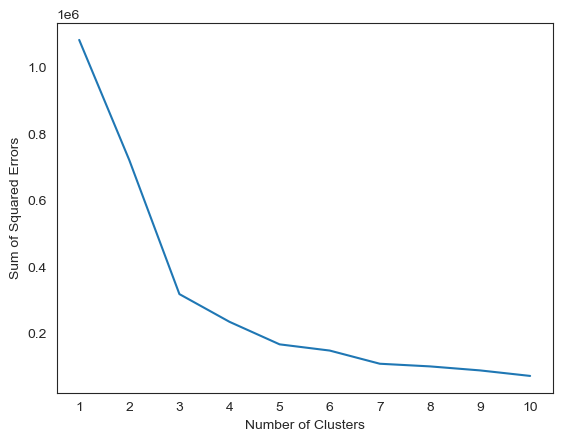

In [197]:
# k calculation method
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_tsne)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)

plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")

plt.show()

From the resulting graph, you must select the strongest inflection. We do this with the help of the kneed library

In [199]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing")

print('Optimal number of clusters:', kl.elbow)

Optimal number of clusters: 3


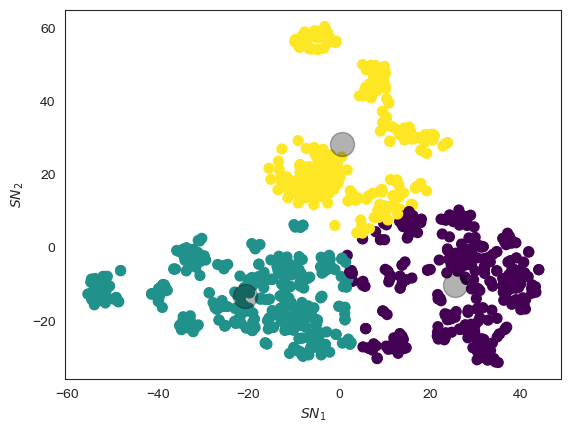

In [207]:
# the number of clusters to form as well as the number of centroids to generate
n_clusters = kl.elbow

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_tsne)

y_tsne = kmeans.predict(X_tsne)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.3);
plt.xlabel(r'$SN_1$')
plt.ylabel(r'$SN_2$')

plt.show()

Okay, but as we can see the "yellow" cluster is divided into two parts, so let's try another method for choosing the number of clusters - the hierarchical method. The advantage of this method is its high illustrative value.

**Hierarchical method**

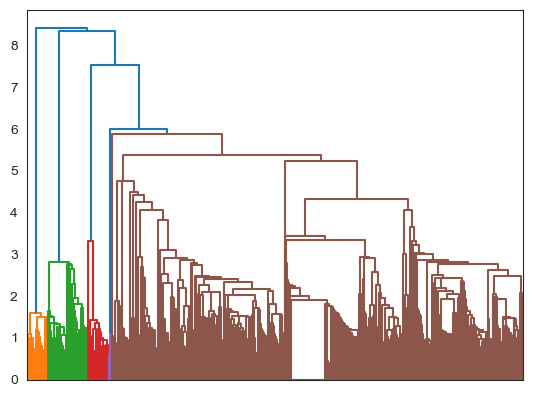

In [212]:
Z = hierarchy.linkage(X_tsne, 'single')
hierarchy.dendrogram(Z)

plt.xticks([])
plt.show()

Hierarchical method using the method of minimum distances between samples identified 4 main clusters.

So to split into 4 clusters, let's try one of the **Expectation-maximization Clustering** methods. The main "tool" that is used for this clusterization model is Gaussian Mixture Models (GMM). The advantage of this method is that the borders of each cluster compose ellipsoids of different measures. However, this method can only be used with a predetermined number of clusters.

**Gaussian Mixture Models**

Let's set the functions for the reconciliation of the GMM method

In [221]:
def draw_ellipse(position, covariances_, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # convert covariance to principal axes
    if covariances_.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariances_)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariances_)

    # draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    sns.set_style("white")
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

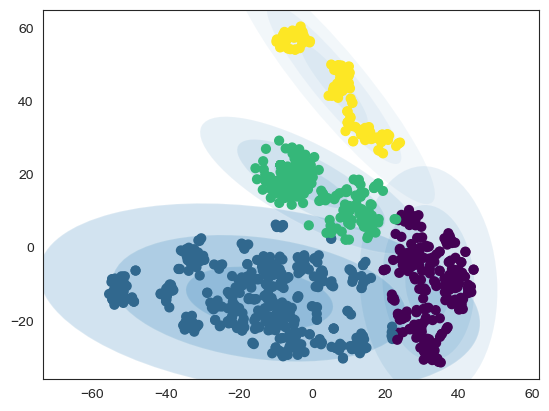

In [228]:
# perform GMM
gmm = GaussianMixture(n_components=4, covariance_type='full').fit(X_tsne)

labels = gmm.predict(X_tsne)

# use the functions to draw the plots
plot_gmm(gmm, X_tsne)

This method produces the expected result, it splits the top cluster into two.

**Interpretation of clustering results**

Let's plot the dependencies of some parameters for connections from each cluster

In [295]:
df = pd.read_csv('df/6_clear.csv')

In [299]:
# set a new column depending on the obtained clusters
df['cluster'] = labels

<Axes: xlabel='cluster', ylabel='TSRW10'>

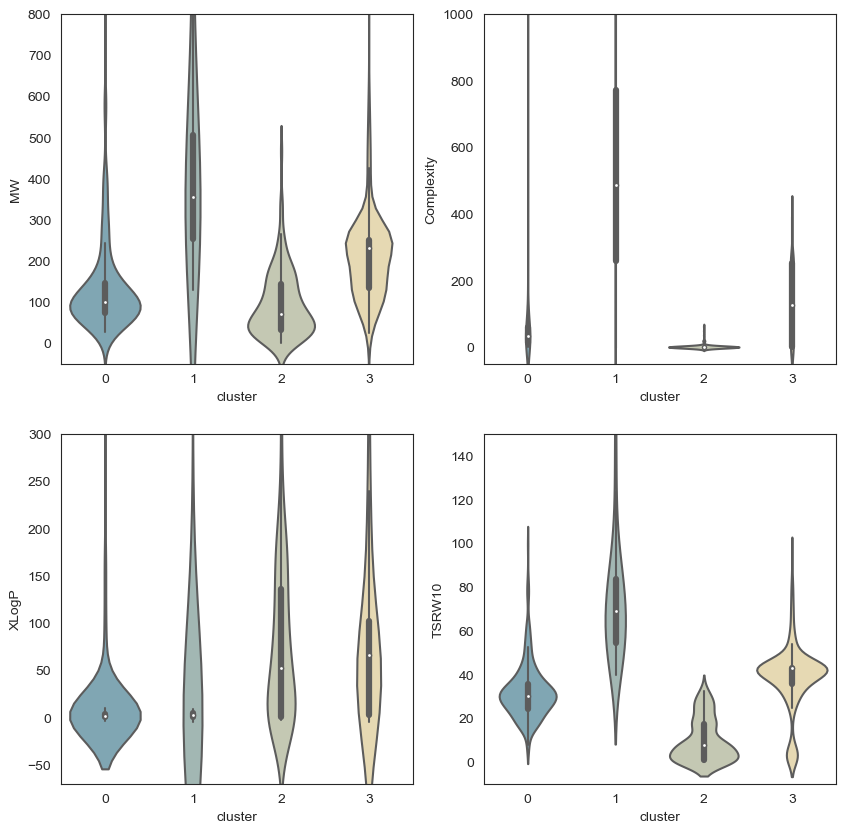

In [348]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# set limits
axes[0, 0].set_ylim(-50, 800)
axes[0, 1].set_ylim(-50, 1000)
axes[1, 0].set_ylim(-70, 300)
axes[1, 1].set_ylim(-10, 150)

# make plots
sns.violinplot(ax=axes[0, 0], 
            data=df, 
            x='cluster', 
            y='MW', 
            palette="blend:#7AB,#EDA")

sns.violinplot(ax=axes[0, 1], 
            data=df, 
            x='cluster', 
            y='Complexity', 
            palette="blend:#7AB,#EDA")

sns.violinplot(ax=axes[1, 0], 
            data=df, 
            x='cluster', 
            y='XLogP', 
            palette="blend:#7AB,#EDA")

sns.violinplot(ax=axes[1, 1], 
            data=df, 
            x='cluster', 
            y='TSRW10', 
            palette="blend:#7AB,#EDA")

As we can see the samples are separated by parameters between different clusters, which were obtained by the GMM method

### Feature engineering

ДОПИСАТЬ

### Feature selection

ДОПИСАТЬ